# Tutorial XII - Passenger Flow Control in Urban Rail

Applied Optimization with Julia

# Introduction

# Solutions

You will likely find solutions to most exercises online. However, I
strongly encourage you to work on these exercises independently without
searching explicitly for the exact answers to the exercises.
Understanding someone else’s solution is very different from developing
your own. Use the lecture notes and try to solve the exercises on your
own. This approach will significantly enhance your learning and
problem-solving skills.

Remember, the goal is not just to complete the exercises, but to
understand the concepts and improve your programming abilities. If you
encounter difficulties, review the lecture materials, experiment with
different approaches, and don’t hesitate to ask for clarification during
class discussions.



Consider the depicted ‘Golden Line’ on the left with 4 different
stations A, B, C, D. For an upcoming timeframe of **10 minutes divided
into 10 periods**, the transportation demand is going to exceed the
available capacity of the network and each origin-destination pair will
be requested by at least 1 passenger. **To handle the inflow, queues
will be put in place at each metro station.**

# The Challenge

Your task is to **minimize the queues** without exceeding the available
transport capacity of **max. 100 passengers per minute of each arc**. A
safety buffer per arc is not needed. Each station layout is excellent,
with sufficient stairs and escalators. Thus, the station itself is fully
capable of handling any inflow that may result from the optimized
restricted inflow. Nonetheless, queues are still necessary as the arcs
cannot handle each input.

# 1. Flow Analysis

Suppose we are in minute 7 at the arc of (D,A). Which inflows from which
stations are going to impact the flow into the arc in this minute?

Write out the set $\mathcal{R}_{(D,A),7}$ and **shortly explain** your
answer. You can write out the set in a comment, for example like this:

``` julia
#=
{(A,B,1), (B,C,1), (C,D,1)}
=#
```

> **Tip**
>
> To solve this task, it might be helpful to work with paper and pen to
> sketch the problem.

In [2]:
#=
YOUR ANSWER BELOW
{
    (D,A,7),
    (C,A,6),
    (B,A,4),
    (D,B,7),
    (D,C,7),
    (C,B,6),
}
=#

# 2. Inflow Control

<figure>
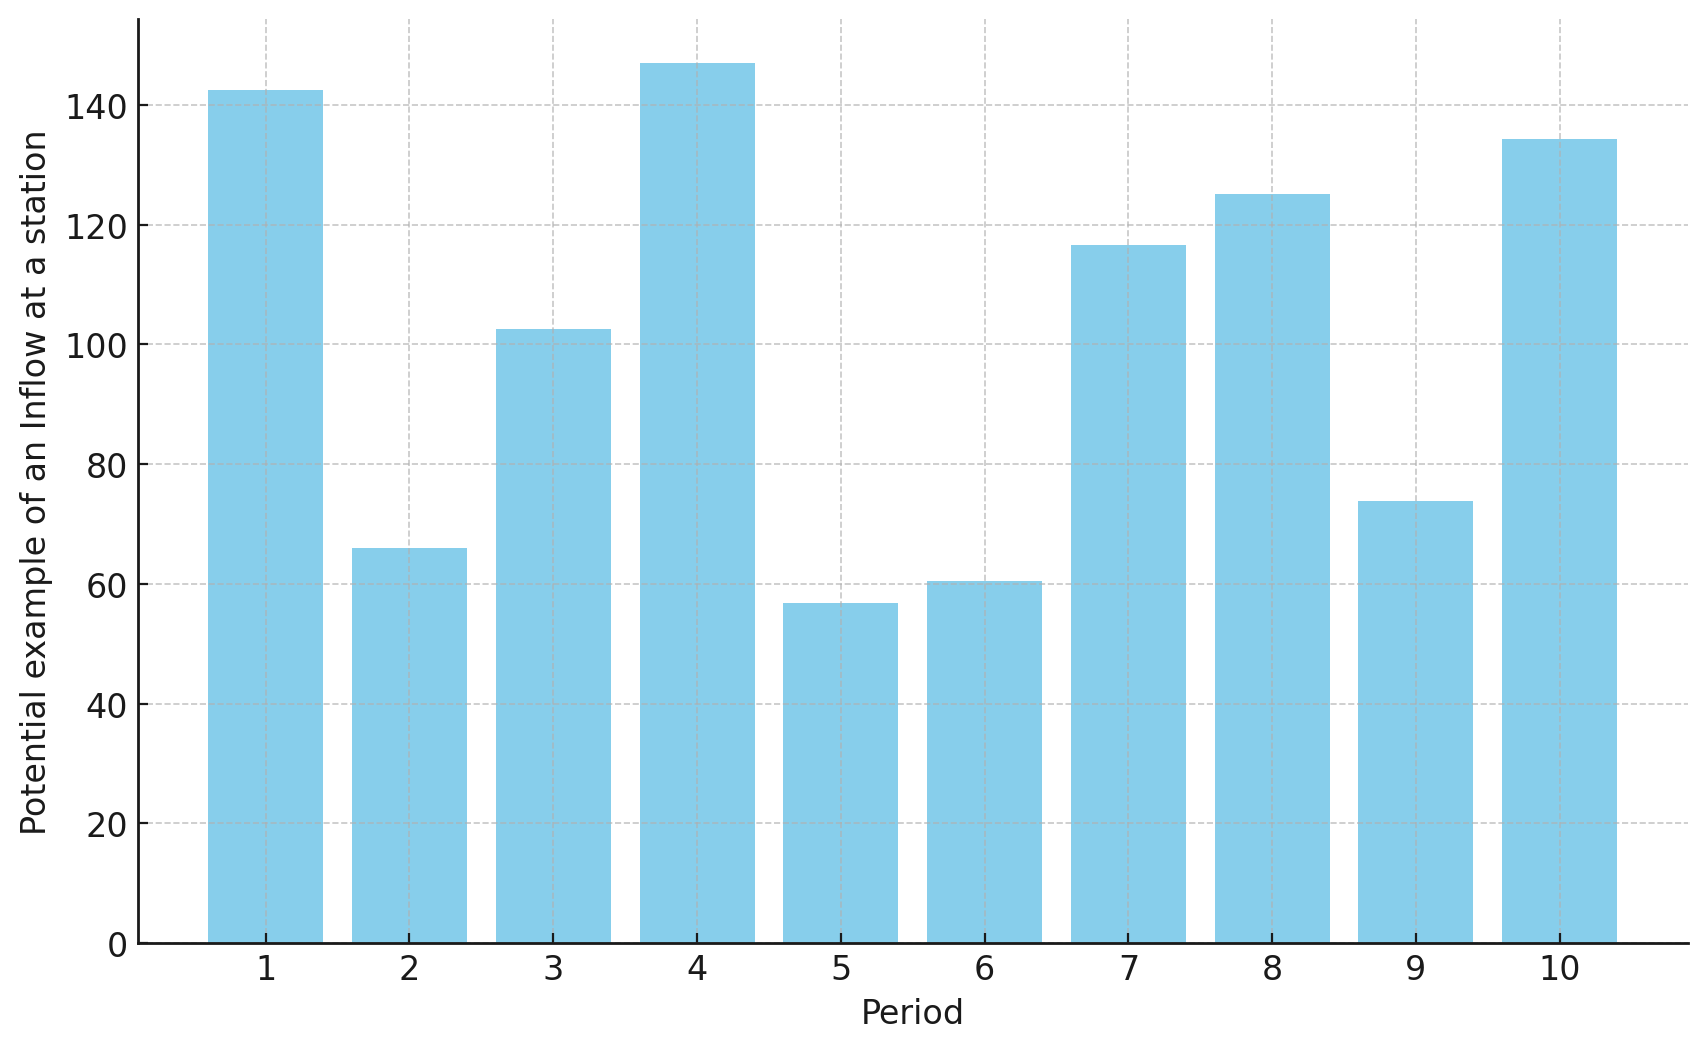
<figcaption aria-hidden="true">Example: Fluctuations</figcaption>
</figure>

<figure>
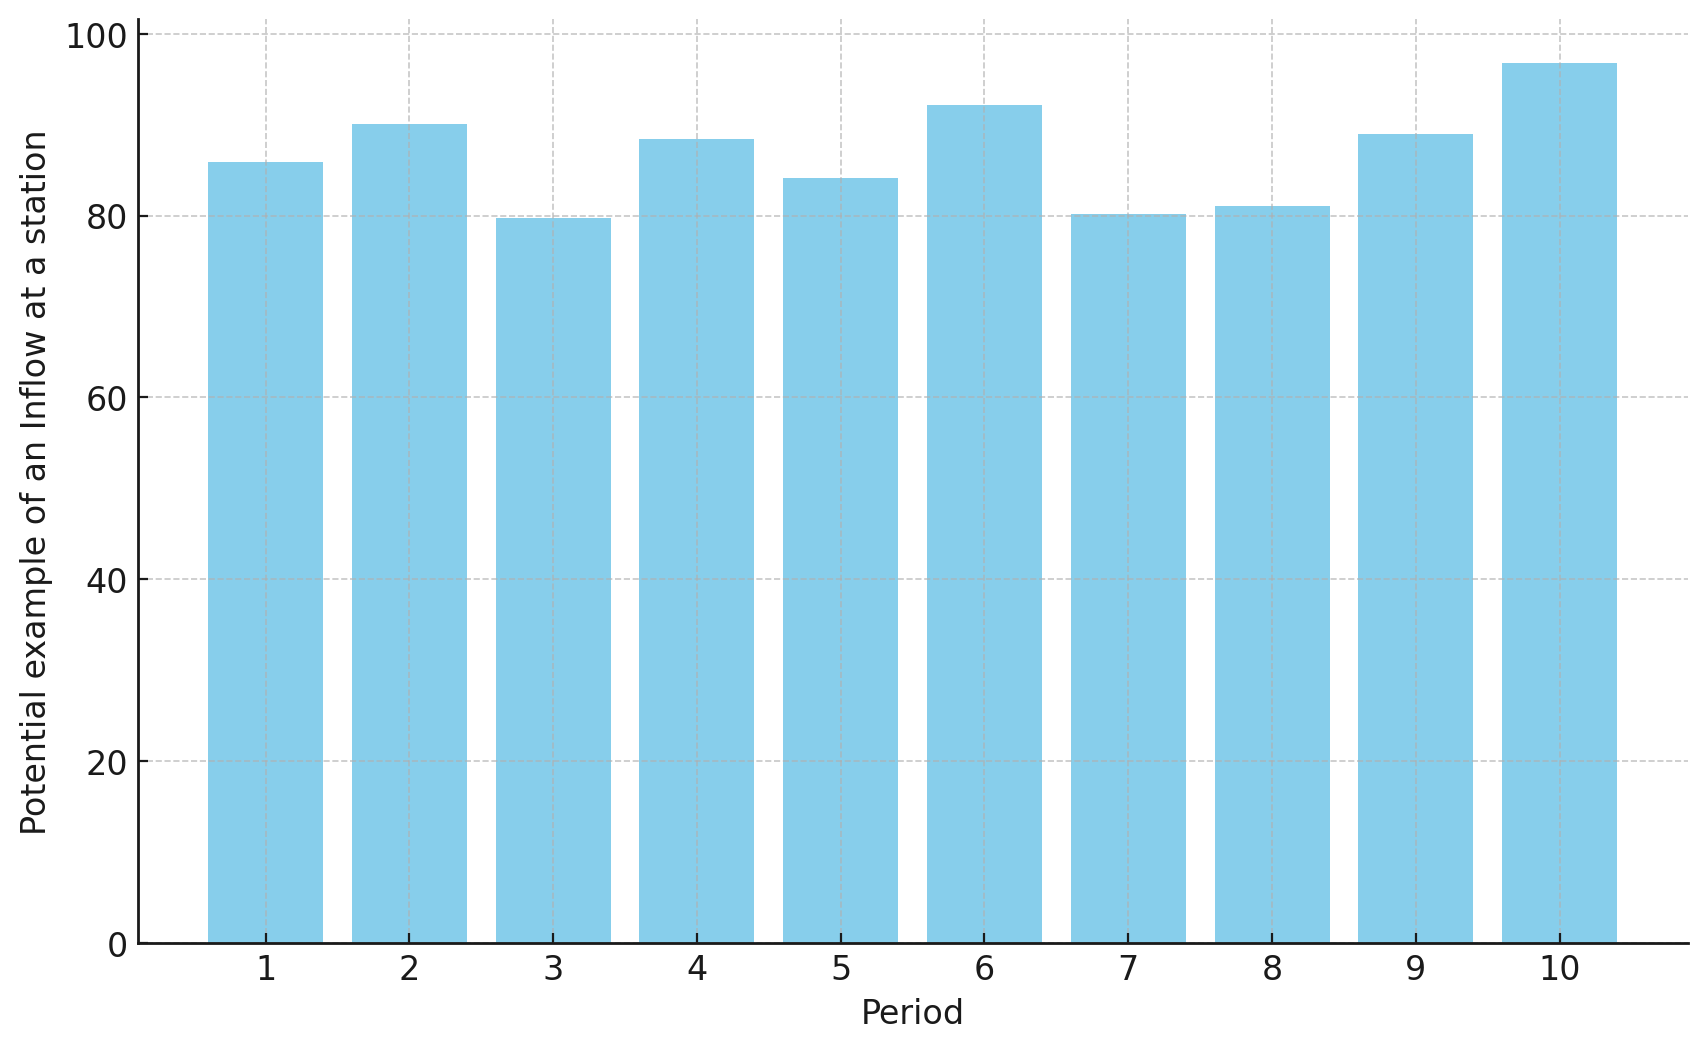
<figcaption aria-hidden="true">Example: Smoothed</figcaption>
</figure>

As there is a rather large fluctuation of allowed inflow between
periods, you are asked to introduce new constraints for the model. In
the first period, the inflow at each station is supposed to be
unrestricted. Thereafter, it is maximally allowed to change by 20
persons in both directions per period at each station.

Can you write out the decision variables and the additional constraints
for the model as JuMP constraints?

> **Tip**
>
> You don’t need to solve the model or define the objective function.
> You just need to constraint the fluctuations and add the appropriate
> variables.

In [4]:
using JuMP
metro_model = Model()

# YOUR CODE BELOW
set_stations = [:A, :B, :C, :D]
set_periods = 1:10
@variable(metro_model, x[i in set_stations, p in set_periods] >= 0)
@constraint(metro_model, upper_bound[i in set_stations, p in set_periods; p > 1], x[i, p] - x[i, p-1] <= 20)
@constraint(metro_model, lower_bound[i in set_stations, p in set_periods; p > 1], x[i, p] - x[i, p-1] >= -20)

# 3. Bidirectional Flow

<figure>

<figcaption aria-hidden="true">Bidirectional Metro Network</figcaption>
</figure>

The metro was improved and there is now the possibility to travel in
both directions. How would this change the set $\mathcal{R}_{(MD,MA),7}$
from 1.?

Write out the new set $\mathcal{R}_{(D,A),7}$ manually and shortly
explain your answer.

In [6]:
#=
# YOUR ANSWER BELOW
{
    (C, A, 6),
    (D, A, 7)
}
In case we acknowledge, that the travel time on some paths is identical, we can also include more entries such as (B,A,4).
=#

# 4. Capacity Analysis

Although the system is two-directional now, the **overall number of
trains of the metro provider has not changed**. Would the change from a
one-directional metro system to a two-directional metro system decrease
the likelihood of crowd-accidents due to insufficient arc-capacities?

Please explain your answer in a few sentences.

In [8]:
#=
# YOUR ANSWER BELOW
That does really depend on the actual demand for the different OD-pairs. Depending on the demand we can find cases where the two-directional flow is better and cases where the one-directional flow is better.

=#

# 5. Computing the Set $\mathcal{R}_{e,t}$

Can you compute the set $\mathcal{R}_{e,t}$ for the one-directional
flow? Generate a dictionary $R$ that contains $e \times t$ entries. Each
entry $r_{e,t}$ should contain a vector with all origin-destination
pairs and the corresponding time period saved as a tuple. Use the
results to check your answer from the first task.

> **Note**
>
> This task can be a bit tricky, as it is a bit of a challenge. But as
> it is the last tutorial, I figured a small challenge is fine.

In [10]:
# YOUR CODE BELOW
# Solution for one directional flow
R = Dict()

Minutes = 1:10
Stations = [:A, :B, :C, :D]
OD_pairs = [(o, d) for o in Stations, d in Stations if o != d]
Arcs = [(:A, :B), (:B, :C), (:C, :D), (:D, :A)]

dist_dict = Dict(
    (:A, :B) => 4,
    (:B, :C) => 2,
    (:C, :D) => 1,
    (:D, :A) => 1
)

# Define paths for each origin-destination pair
paths = Dict(
    (:A, :B) => [(:A, :B)],
    (:A, :C) => [(:A, :B), (:B, :C)],
    (:A, :D) => [(:A, :B), (:B, :C), (:C, :D)],
    (:B, :C) => [(:B, :C)],
    (:B, :D) => [(:B, :C), (:C, :D)],
    (:B, :A) => [(:B, :C), (:C, :D), (:D, :A)],
    (:C, :D) => [(:C, :D)],
    (:C, :A) => [(:C, :D), (:D, :A)],
    (:C, :B) => [(:C, :D), (:D, :A), (:A, :B)],
    (:D, :A) => [(:D, :A)],
    (:D, :B) => [(:D, :A), (:A, :B)],
    (:D, :C) => [(:D, :A), (:A, :B), (:B, :C)]
)

# Calculate total travel time for each OD pair
travel_times = Dict()
for (od_pair, path) in paths
    travel_times[od_pair] = sum(dist_dict[arc] for arc in path)
end
for station in Stations
    travel_times[(station, station)] = 0
end

# Display the travel times
for (od_pair, time) in travel_times
    println("Time from $(od_pair[1]) to $(od_pair[2]): $time minutes")
end

# Populate R with tuples (o, d, p) based on the given conditions
for e in Arcs
    for t in Minutes
        R[(e, t)] = [
            (o, d, tt)
            for (o, d) in OD_pairs
            for tt in Minutes
            if e in paths[(o, d)] && (t - travel_times[(o,e[1])] == tt) && (tt >= 1) && (tt <= 10)
        ]
    end
end

# Display the computed R for verification
for e in Arcs
    for t in Minutes
        println("R[($e), $t] = ", R[(e, t)])
    end
end

Time from D to D: 0 minutes
Time from C to A: 2 minutes
Time from C to C: 0 minutes
Time from A to C: 6 minutes
Time from D to B: 5 minutes
Time from B to B: 0 minutes
Time from B to D: 3 minutes
Time from A to D: 7 minutes
Time from C to D: 1 minutes
Time from B to C: 2 minutes
Time from A to B: 4 minutes
Time from A to A: 0 minutes
Time from C to B: 6 minutes
Time from B to A: 4 minutes
Time from D to A: 1 minutes
Time from D to C: 7 minutes
R[((:A, :B)), 1] = [(:A, :B, 1), (:A, :C, 1), (:A, :D, 1)]
R[((:A, :B)), 2] = [(:A, :B, 2), (:D, :B, 1), (:A, :C, 2), (:D, :C, 1), (:A, :D, 2)]
R[((:A, :B)), 3] = [(:A, :B, 3), (:C, :B, 1), (:D, :B, 2), (:A, :C, 3), (:D, :C, 2), (:A, :D, 3)]
R[((:A, :B)), 4] = [(:A, :B, 4), (:C, :B, 2), (:D, :B, 3), (:A, :C, 4), (:D, :C, 3), (:A, :D, 4)]
R[((:A, :B)), 5] = [(:A, :B, 5), (:C, :B, 3), (:D, :B, 4), (:A, :C, 5), (:D, :C, 4), (:A, :D, 5)]
R[((:A, :B)), 6] = [(:A, :B, 6), (:C, :B, 4), (:D, :B, 5), (:A, :C, 6), (:D, :C, 5), (:A, :D, 6)]
R[((:A, :B)), 7]

In [11]:
# YOUR CODE BELOW
# Solution for bi-directional flow
R = Dict()

Minutes = 1:10
Stations = [:A, :B, :C, :D]
OD_pairs = [(o, d) for o in Stations, d in Stations if o != d]
Arcs = [
    (:A, :B),
    (:B, :C),
    (:C, :D),
    (:D, :A),
    (:B, :A),
    (:C, :B),
    (:D, :C),
    (:A, :D),
]

dist_dict = Dict(
    (:A, :B) => 4,
    (:B, :C) => 2,
    (:C, :D) => 1,
    (:D, :A) => 1,
    (:B, :A) => 4,
    (:C, :B) => 2,
    (:D, :C) => 1,
    (:A, :D) => 1
)

# Define paths for each shortest path origin-destination pair
paths = Dict(
    (:A, :B) => [(:A, :B)],
    (:A, :C) => [(:A, :D), (:D, :C)],
    (:A, :D) => [(:A, :D)],
    (:B, :C) => [(:B, :C)],
    (:B, :D) => [(:B, :C), (:C, :D)],
    (:B, :A) => [(:B, :A)],
    (:C, :D) => [(:C, :D)],
    (:C, :A) => [(:C, :D), (:D, :A)],
    (:C, :B) => [(:C, :B)],
    (:D, :A) => [(:D, :A)],
    (:D, :B) => [(:D, :C), (:C, :B)],
    (:D, :C) => [(:D, :C)]
)

# Calculate total travel time for each OD pair
travel_times = Dict()
for (od_pair, path) in paths
    travel_times[od_pair] = sum(dist_dict[arc] for arc in path)
end
for station in Stations
    travel_times[(station, station)] = 0
end

# Display the travel times
for (od_pair, time) in travel_times
    println("Time from $(od_pair[1]) to $(od_pair[2]): $time minutes")
end

# Populate R with tuples (o, d, p) based on the given conditions
for e in Arcs
    for t in Minutes
        R[(e, t)] = [
            (o, d, tt)
            for (o, d) in OD_pairs
            for tt in Minutes
            if e in paths[(o, d)] && (t - travel_times[(o,e[1])] == tt) && (tt >= 1) && (tt <= 10)
        ]
    end
end

# Display the computed R for verification
for e in Arcs
    for t in Minutes
        println("R[($e), $t] = ", R[(e, t)])
    end
end

Time from D to D: 0 minutes
Time from C to A: 2 minutes
Time from C to C: 0 minutes
Time from A to C: 2 minutes
Time from D to B: 3 minutes
Time from B to B: 0 minutes
Time from B to D: 3 minutes
Time from A to D: 1 minutes
Time from C to D: 1 minutes
Time from B to C: 2 minutes
Time from A to B: 4 minutes
Time from A to A: 0 minutes
Time from C to B: 2 minutes
Time from B to A: 4 minutes
Time from D to A: 1 minutes
Time from D to C: 1 minutes
R[((:A, :B)), 1] = [(:A, :B, 1)]
R[((:A, :B)), 2] = [(:A, :B, 2)]
R[((:A, :B)), 3] = [(:A, :B, 3)]
R[((:A, :B)), 4] = [(:A, :B, 4)]
R[((:A, :B)), 5] = [(:A, :B, 5)]
R[((:A, :B)), 6] = [(:A, :B, 6)]
R[((:A, :B)), 7] = [(:A, :B, 7)]
R[((:A, :B)), 8] = [(:A, :B, 8)]
R[((:A, :B)), 9] = [(:A, :B, 9)]
R[((:A, :B)), 10] = [(:A, :B, 10)]
R[((:B, :C)), 1] = [(:B, :C, 1), (:B, :D, 1)]
R[((:B, :C)), 2] = [(:B, :C, 2), (:B, :D, 2)]
R[((:B, :C)), 3] = [(:B, :C, 3), (:B, :D, 3)]
R[((:B, :C)), 4] = [(:B, :C, 4), (:B, :D, 4)]
R[((:B, :C)), 5] = [(:B, :C, 5), (:B

# 6. Bonus: Metro Flow Simulation (0.5 points)

Now, you can earn up to 0.5 additional bonus points by building a
simulation of passenger flows through a metro network. The network
consists of two lines with a shared transfer station. Passengers enter
at stations A, B, C, D and travel to various destinations.

First, study the network data below to understand the structure and then
implement a minute-by-minute simulation that tracks the queues at entry
stations, passenger flows through arcs and arc utilization over time.
Then, visualize the results with some plots and try to implement inflow
regulation to achieve a feasible solution (no arc exceeds capacity).

> **Tip**
>
> Good luck! This is really a tough task.

In [14]:
# Stations and arcs
stations = [:A, :B, :C, :D, :T, :E, :F]
entry_stations = [:A, :B, :C, :D]
arcs = [(:A, :B), (:B, :T), (:T, :E), (:C, :D), (:D, :T), (:T, :F)]

# Network parameters
travel_time = 1  # minutes per arc
arc_capacity = 100  # passengers per minute
n_minutes = 20  # total simulation time

# Inflow regulation: single constant rate per station (passengers/minute)
# Set to 1000 (no regulation) initially - experiment to find feasible values
inflow_rates = Dict(:A => 1000, :B => 1000, :C => 1000, :D => 1000)

# Paths for each OD pair
paths = Dict(
    (:A, :B) => [(:A, :B)],
    (:A, :E) => [(:A, :B), (:B, :T), (:T, :E)],
    (:A, :F) => [(:A, :B), (:B, :T), (:T, :F)],
    (:B, :E) => [(:B, :T), (:T, :E)],
    (:B, :F) => [(:B, :T), (:T, :F)],
    (:C, :D) => [(:C, :D)],
    (:C, :F) => [(:C, :D), (:D, :T), (:T, :F)],
    (:C, :E) => [(:C, :D), (:D, :T), (:T, :E)],
    (:D, :F) => [(:D, :T), (:T, :F)],
    (:D, :E) => [(:D, :T), (:T, :E)]
)

# Demand data: demand[period][(origin, destination)] = passengers
# Note: Peak demand (periods 3-6) exceeds arc capacity, requiring inflow regulation
demand = Dict(
    1 => Dict((:A,:B)=>7,  (:A,:E)=>12, (:A,:F)=>5,  (:B,:E)=>15, (:B,:F)=>10,
              (:C,:D)=>5,  (:C,:F)=>10, (:C,:E)=>8,  (:D,:F)=>15, (:D,:E)=>12),
    2 => Dict((:A,:B)=>8,  (:A,:E)=>15, (:A,:F)=>10, (:B,:E)=>18, (:B,:F)=>15,
              (:C,:D)=>8,  (:C,:F)=>15, (:C,:E)=>10, (:D,:F)=>18, (:D,:E)=>15),
    3 => Dict((:A,:B)=>12, (:A,:E)=>22, (:A,:F)=>18, (:B,:E)=>28, (:B,:F)=>22,
              (:C,:D)=>12, (:C,:F)=>22, (:C,:E)=>15, (:D,:F)=>28, (:D,:E)=>18),
    4 => Dict((:A,:B)=>15, (:A,:E)=>28, (:A,:F)=>22, (:B,:E)=>32, (:B,:F)=>28,
              (:C,:D)=>15, (:C,:F)=>28, (:C,:E)=>27, (:D,:F)=>32, (:D,:E)=>22),
    5 => Dict((:A,:B)=>15, (:A,:E)=>28, (:A,:F)=>22, (:B,:E)=>32, (:B,:F)=>28,
              (:C,:D)=>15, (:C,:F)=>28, (:C,:E)=>18, (:D,:F)=>32, (:D,:E)=>22),
    6 => Dict((:A,:B)=>12, (:A,:E)=>22, (:A,:F)=>18, (:B,:E)=>22, (:B,:F)=>18,
              (:C,:D)=>12, (:C,:F)=>22, (:C,:E)=>15, (:D,:F)=>22, (:D,:E)=>21),
    7 => Dict((:A,:B)=>8,  (:A,:E)=>15, (:A,:F)=>10, (:B,:E)=>18, (:B,:F)=>15,
              (:C,:D)=>8,  (:C,:F)=>15, (:C,:E)=>10, (:D,:F)=>18, (:D,:E)=>15),
    8 => Dict((:A,:B)=>5,  (:A,:E)=>10, (:A,:F)=>5,  (:B,:E)=>15, (:B,:F)=>10,
              (:C,:D)=>5,  (:C,:F)=>10, (:C,:E)=>5,  (:D,:F)=>15, (:D,:E)=>10)
)


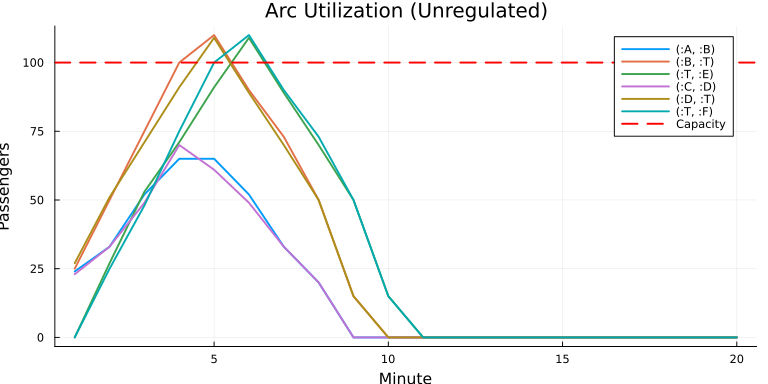


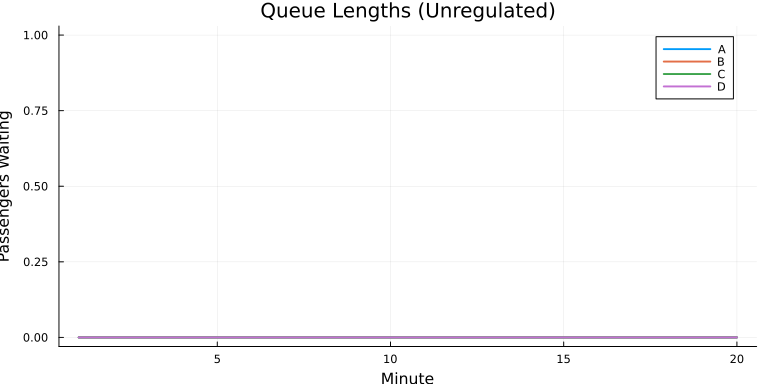


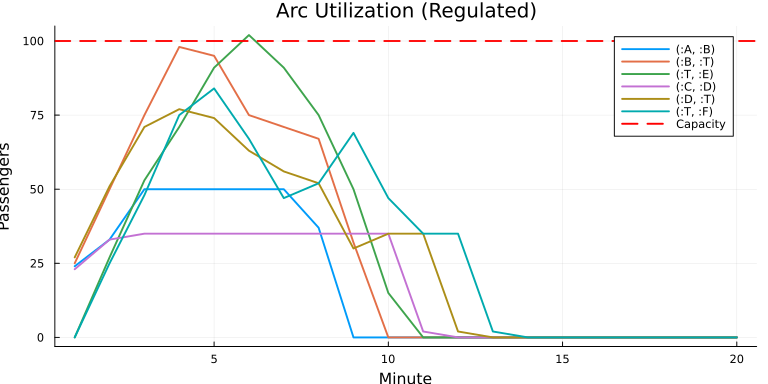


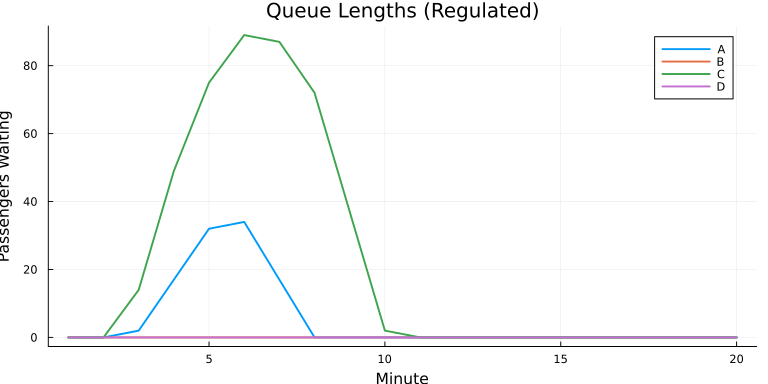

Results Summary
Unregulated: Moved 1323 passengers
  Max arc utilization: 109 (capacity: 100)
  Feasible: false
Regulated: Moved 1323 passengers
  Max arc utilization: 77 (capacity: 100)
  Feasible: true

The regulated solution achieves feasibility by spreading
peak demand over time, creating queues at entry stations.

In [15]:
using Plots

# Network data
stations = [:A, :B, :C, :D, :T, :E, :F]
entry_stations = [:A, :B, :C, :D]
arcs = [(:A, :B), (:B, :T), (:T, :E), (:C, :D), (:D, :T), (:T, :F)]
travel_time = 1
arc_capacity = 100
n_minutes = 20

paths = Dict(
    (:A, :B) => [(:A, :B)],
    (:A, :E) => [(:A, :B), (:B, :T), (:T, :E)],
    (:A, :F) => [(:A, :B), (:B, :T), (:T, :F)],
    (:B, :E) => [(:B, :T), (:T, :E)],
    (:B, :F) => [(:B, :T), (:T, :F)],
    (:C, :D) => [(:C, :D)],
    (:C, :F) => [(:C, :D), (:D, :T), (:T, :F)],
    (:C, :E) => [(:C, :D), (:D, :T), (:T, :E)],
    (:D, :F) => [(:D, :T), (:T, :F)],
    (:D, :E) => [(:D, :T), (:T, :E)]
)

demand = Dict(
    1 => Dict((:A,:B)=>7,  (:A,:E)=>12, (:A,:F)=>5,  (:B,:E)=>15, (:B,:F)=>10,
              (:C,:D)=>5,  (:C,:F)=>10, (:C,:E)=>8,  (:D,:F)=>15, (:D,:E)=>12),
    2 => Dict((:A,:B)=>8,  (:A,:E)=>15, (:A,:F)=>10, (:B,:E)=>18, (:B,:F)=>15,
              (:C,:D)=>8,  (:C,:F)=>15, (:C,:E)=>10, (:D,:F)=>18, (:D,:E)=>15),
    3 => Dict((:A,:B)=>12, (:A,:E)=>22, (:A,:F)=>18, (:B,:E)=>28, (:B,:F)=>22,
              (:C,:D)=>12, (:C,:F)=>22, (:C,:E)=>15, (:D,:F)=>28, (:D,:E)=>18),
    4 => Dict((:A,:B)=>15, (:A,:E)=>28, (:A,:F)=>22, (:B,:E)=>32, (:B,:F)=>28,
              (:C,:D)=>15, (:C,:F)=>28, (:C,:E)=>27, (:D,:F)=>32, (:D,:E)=>22),
    5 => Dict((:A,:B)=>15, (:A,:E)=>28, (:A,:F)=>22, (:B,:E)=>32, (:B,:F)=>28,
              (:C,:D)=>15, (:C,:F)=>28, (:C,:E)=>18, (:D,:F)=>32, (:D,:E)=>22),
    6 => Dict((:A,:B)=>12, (:A,:E)=>22, (:A,:F)=>18, (:B,:E)=>22, (:B,:F)=>18,
              (:C,:D)=>12, (:C,:F)=>22, (:C,:E)=>15, (:D,:F)=>22, (:D,:E)=>21),
    7 => Dict((:A,:B)=>8,  (:A,:E)=>15, (:A,:F)=>10, (:B,:E)=>18, (:B,:F)=>15,
              (:C,:D)=>8,  (:C,:F)=>15, (:C,:E)=>10, (:D,:F)=>18, (:D,:E)=>15),
    8 => Dict((:A,:B)=>5,  (:A,:E)=>10, (:A,:F)=>5,  (:B,:E)=>15, (:B,:F)=>10,
              (:C,:D)=>5,  (:C,:F)=>10, (:C,:E)=>5,  (:D,:F)=>15, (:D,:E)=>10)
)

# Inflow rates: single constant rate per station (no regulation = 1000)
inflow_rates_unregulated = Dict(:A => 1000, :B => 1000, :C => 1000, :D => 1000)

# Regulated inflow rates (found through experimentation)
# Key insight: T->E and T->F are the bottlenecks (capacity 100 each)
# All traffic to E and F must pass through T
# Example feasible solution - students should experiment to find their own!
inflow_rates_regulated = Dict(:A => 50, :B => 70, :C => 35, :D => 70)

function simulate_metro(demand, inflow_rates, paths, arcs, arc_capacity, n_minutes)
    # Initialize queues: queues[station][(o,d)] = number waiting
    queues = Dict(s => Dict{Tuple{Symbol,Symbol}, Int}() for s in entry_stations)
    
    # Initialize arc utilization tracking
    arc_util = Dict(a => zeros(Int, n_minutes) for a in arcs)
    
    # Track passengers in transit: in_transit[minute_arriving][arc] = count
    in_transit = [Dict(a => 0 for a in arcs) for _ in 1:n_minutes+10]
    
    # Track queue lengths over time
    queue_history = Dict(s => zeros(Int, n_minutes) for s in entry_stations)
    
    total_moved = 0
    
    for t in 1:n_minutes
        # Add new demand to queues (only in periods 1-8)
        if t <= 8
            for ((o, d), count) in demand[t]
                if o in entry_stations
                    if !haskey(queues[o], (o, d))
                        queues[o][(o, d)] = 0
                    end
                    queues[o][(o, d)] += count
                end
            end
        end
        
        # Process inflow at each entry station (FIFO by arrival order)
        for station in entry_stations
            max_inflow = inflow_rates[station]  # constant rate per station
            allowed = max_inflow
            
            # Process queues for this station
            for ((o, d), waiting) in sort(collect(queues[station]))
                if allowed <= 0 || waiting <= 0
                    continue
                end
                
                # How many can we send?
                to_send = min(waiting, allowed)
                queues[station][(o, d)] -= to_send
                allowed -= to_send
                total_moved += to_send
                
                # Add to transit on first arc of path
                path = paths[(o, d)]
                first_arc = path[1]
                arrival_time = t + travel_time
                if arrival_time <= n_minutes
                    in_transit[arrival_time][first_arc] += to_send
                end
                
                # Schedule for subsequent arcs
                for (i, arc) in enumerate(path)
                    arc_time = t + i - 1
                    if arc_time <= n_minutes
                        arc_util[arc][arc_time] += to_send
                    end
                end
            end
        end
        
        # Record queue lengths
        for station in entry_stations
            queue_history[station][t] = sum(values(queues[station]))
        end
    end
    
    return arc_util, queue_history, total_moved
end

# Run unregulated simulation
arc_util_unreg, queue_unreg, moved_unreg = simulate_metro(
    demand, inflow_rates_unregulated, paths, arcs, arc_capacity, n_minutes)

# Plot unregulated results
p1 = plot(title="Arc Utilization (Unregulated)", xlabel="Minute", ylabel="Passengers",
          legend=:topright, size=(800, 400))
for arc in arcs
    plot!(p1, 1:n_minutes, arc_util_unreg[arc], label=string(arc), linewidth=2)
end
hline!(p1, [arc_capacity], color=:red, linestyle=:dash, label="Capacity", linewidth=2)
display(p1)

p2 = plot(title="Queue Lengths (Unregulated)", xlabel="Minute", ylabel="Passengers Waiting",
          legend=:topright, size=(800, 400))
for station in entry_stations
    plot!(p2, 1:n_minutes, queue_unreg[station], label=string(station), linewidth=2)
end
display(p2)

# Run regulated simulation
arc_util_reg, queue_reg, moved_reg = simulate_metro(
    demand, inflow_rates_regulated, paths, arcs, arc_capacity, n_minutes)

# Plot regulated results
p3 = plot(title="Arc Utilization (Regulated)", xlabel="Minute", ylabel="Passengers",
          legend=:topright, size=(800, 400))
for arc in arcs
    plot!(p3, 1:n_minutes, arc_util_reg[arc], label=string(arc), linewidth=2)
end
hline!(p3, [arc_capacity], color=:red, linestyle=:dash, label="Capacity", linewidth=2)
display(p3)

p4 = plot(title="Queue Lengths (Regulated)", xlabel="Minute", ylabel="Passengers Waiting",
          legend=:topright, size=(800, 400))
for station in entry_stations
    plot!(p4, 1:n_minutes, queue_reg[station], label=string(station), linewidth=2)
end
display(p4)

println("="^50)
println("Results Summary")
println("="^50)
println("Unregulated: Moved $moved_unreg passengers")
println("  Max arc utilization: ", maximum(maximum(values(arc_util_unreg))), " (capacity: $arc_capacity)")
println("  Feasible: ", maximum(maximum(values(arc_util_unreg))) <= arc_capacity)
println("Regulated: Moved $moved_reg passengers")
println("  Max arc utilization: ", maximum(maximum(values(arc_util_reg))), " (capacity: $arc_capacity)")
println("  Feasible: ", maximum(maximum(values(arc_util_reg))) <= arc_capacity)
println("\nThe regulated solution achieves feasibility by spreading")
println("peak demand over time, creating queues at entry stations.")

# Solutions

You will likely find solutions to most exercises online. However, I
strongly encourage you to work on these exercises independently without
searching explicitly for the exact answers to the exercises.
Understanding someone else’s solution is very different from developing
your own. Use the lecture notes and try to solve the exercises on your
own. This approach will significantly enhance your learning and
problem-solving skills.

Remember, the goal is not just to complete the exercises, but to
understand the concepts and improve your programming abilities. If you
encounter difficulties, review the lecture materials, experiment with
different approaches, and don’t hesitate to ask for clarification during
class discussions.